# 사전 학습된 CNN(VGG-16)을 이용한 Fine Tunig
## VGG-16 Model
* University of Oxford - Visual Geometry Group
* 2014 ILSVRC 2nd Model
* ImageNet Large Scale Visual Recognition Challenge (ILSVRC)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

* Import TensorFlow

In [ ]:
import tensorflow as tf

tf.__version__

'2.15.0'

# I. wget From Github
* 'dogs_and_cats_small.zip' 파일 다운로드

In [ ]:
!wget https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip

--2024-01-23 13:50:38--  https://raw.githubusercontent.com/rusita-ai/pyData/master/dogs_and_cats_small.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90618980 (86M) [application/zip]
Saving to: ‘dogs_and_cats_small.zip’

dogs_and_cats_small 100%[===================>]  86.42M   207MB/s    in 0.4s    

2024-01-23 13:50:41 (207 MB/s) - ‘dogs_and_cats_small.zip’ saved [90618980/90618980]



* 다운로드 결과 확인

In [ ]:
!ls -l

total 88500
-rw-r--r-- 1 root root 90618980 Jan 23 13:50 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Jan 19 14:20 sample_data


# II. Data Preprocessing

> ## 1) Unzip 'dogs_and_cats_small.zip'

In [ ]:
!unzip -q /content/dogs_and_cats_small.zip

* 학습 데이터 확인

In [ ]:
!ls -l

total 88512
-rw-r--r-- 1 root root 90618980 Jan 23 13:50 dogs_and_cats_small.zip
drwxr-xr-x 1 root root     4096 Jan 19 14:20 sample_data
drwxr-xr-x 4 root root     4096 Jan 23 13:50 test
drwxr-xr-x 4 root root     4096 Jan 23 13:50 train
drwxr-xr-x 4 root root     4096 Jan 23 13:50 validation


> ## 2) Image_File Directory Setting

* train_dir,  valid_dir,   * test_dir

In [ ]:
train_dir = './train'
valid_dir = './validation'
test_dir = './test'

# III. Data Preprocessing

> ## 1) ImageDataGenerator( ) & flow_from_directory( )

* Normalization
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_directory( )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# With Augmentation
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   vertical_flip = True,
                                   brightness_range = [0.5, 1.5],
                                   fill_mode = 'nearest')

# With Augmentation
train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

# Without Augmentation
valid_datagen = ImageDataGenerator(rescale = 1./255)

# Without Augmentation
valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# IV. Import VGG-16 Model & Some Layers Freezing

> ## 1) conv_base

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

> ## 2) Model Information

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

> ## 3) 'block5_conv<font color = 'red'>*</font>' Freezing

> ### (1) Before 'weight' Freezing

In [ ]:
# 13개의 conv 레이어 마다 w, b
print('conv_base 동결 전 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 전 훈련 가능 가중치의 종류: 26


* Model Weights Information

In [ ]:
conv_base.get_weights()

In [ ]:
# model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

for i in range(len(conv_base.get_weights())):
    print(i+1, conv_base.get_weights()[i].shape)  # 가중치, 바이어스 반복
    # conv레이어별 각 1개 배열의 w와 b
    # 64개의 필터, 3x3 필터사이즈, rgb의 깊이

1 (3, 3, 3, 64)
2 (64,)
3 (3, 3, 64, 64)
4 (64,)
5 (3, 3, 64, 128)
6 (128,)
7 (3, 3, 128, 128)
8 (128,)
9 (3, 3, 128, 256)
10 (256,)
11 (3, 3, 256, 256)
12 (256,)
13 (3, 3, 256, 256)
14 (256,)
15 (3, 3, 256, 512)
16 (512,)
17 (3, 3, 512, 512)
18 (512,)
19 (3, 3, 512, 512)
20 (512,)
21 (3, 3, 512, 512)
22 (512,)
23 (3, 3, 512, 512)
24 (512,)
25 (3, 3, 512, 512)
26 (512,)


* Model Layers Information

In [ ]:
conv_base.layers

* Layer[-4]'s Name

In [ ]:
conv_base.layers[-4].name

'block5_conv1'

* Layer[-4]'s Weights

In [ ]:
conv_base.layers[-4].weights

> ### (2) <font color = 'blue'>weight' Freezing

In [ ]:
for layer in conv_base.layers[:-4]:
    layer.trainable = False # conv block1~4까지 freazing

> ### (3) After 'weight' Freezing

In [ ]:
#  conv block5의 w와 b
print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 후 훈련 가능 가중치의 종류: 6


* Model Information

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

* 컨볼루션층의 이름을 알고 있을 경우, 아래 코드 처럼 쉽게 설정해도 무방하다.
```python
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    # if set_trainable:
    #     layer.trainable = True
    # else:
    #     layer.trainable = False
```

# V. Keras CNN Modeling with VGG-16 Freezed Layers

> ## 1) Model Define

* 'conv_base' & 'Classification' Network
* Dropout Layer

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential(name = 'CNN_VGG16')
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "CNN_VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dropout_2 (Dropout)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               2097408   
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 9177089 (35.01 MB)
Non-trainable params: 7635264 (29.13 MB)
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정
 * 이미 학습된 Weight 값을 Tuning
 * <font color = 'red'>매우 작은 Learnig Rate 지정</font>
 * optimizers.Adam(lr = 0.000005)

In [ ]:
# vgg16이 5차 함수라고 가정할 때, 최적점과의 위치를 알 수 없으나,
# 모델의 성능을 믿고 가까운 곳에 최적점이 있을 것이라 기대하고 학습률은 매우 미세하게 조정한다.

from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(learning_rate = 0.000005),
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 12분

In [ ]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 30,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/30
100/100 [==============================] - 24s 222ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/30
 15/100 [===>..........................] - ETA: 14s - loss: 0.6931 - accuracy: 0.5000

KeyboardInterrupt: 

> ## 4) 학습 결과 시각화

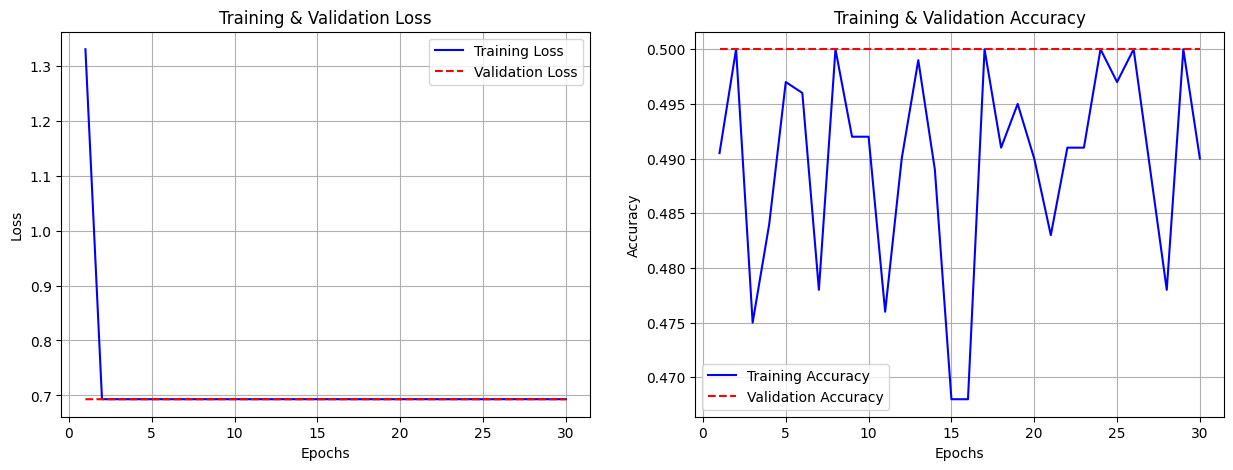

In [ ]:
# validation 성능이 train보다 좋게 나오는 이유는,
# 이미 학습된 가중치들을 사용하고 test데이터보다 훨씬 더 많은 데이터로 훈련을 했기 때문
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, Hist_dandc.history['loss'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_loss'], 'r--')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(epochs, Hist_dandc.history['accuracy'], 'b-')
plt.plot(epochs, Hist_dandc.history['val_accuracy'], 'r--')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()

plt.show()

> ## 5) Model Evaluate

* test_generator

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


* Loss & Accuracy

In [ ]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50,
                                verbose = 0)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

Loss = 0.69315
Accuracy = 0.50000


* 왜 이런 결과가 나올까?

# The End